# Lensed QSO work with Gaia DR2

Using the LQSO Castle match with DR2 as the learning set and apply this to LQSO allwise 2.

Trying with machine learning classification.

The idea is to use the following set of _features_ for each LQSO:

* the total proper motion and its error
* the total parallax and its error
* the astrometric colour
* the distances to the nearest 3 neighbours.

This makes 6 _features_ to feed to the SVM/PCA classification.


In [23]:
import os
import numpy as np

from astropy.table import Table, vstack

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.coordinates import SkyCoord 
import astropy.units as u

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree
from sklearn import tree as sktree
from sklearn.ensemble import RandomForestClassifier
#from IPython.display import Math
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

D2R = np.pi/180.0
home = os.path.expanduser('~')
wdir =  home + '/Dropbox/Work/Gaia-QSO'
dataDir = home + '/Dropbox/Work/Python/MIsc'

In [6]:
# read the Castle xmatch with DR2
#url1 = 'http://vospace.esac.esa.int/vospace/sh/9da5bd4b841f4032ee3f94e2f357067a554434?dl=1'
#t1 = Table.read(url1,format='votable')
file1 = '{}/lqso_castle-result.fits.gz'.format(dataDir)
t1 = Table.read(file1)
nt1 = len(t1)
#

In [7]:
# read the DR2 xmatch with allwise
#url2 = 'http://vospace.esac.esa.int/vospace/sh/d964d4b3687ede95d64c19609abb3136fbe55c0?dl=1'
#t2 = Table.read(url2,format='votable')
file2 = '{}/lqso_allwise2-result.fits.gz'.format(dataDir)
t2 = Table.read(file2)
nt2 = len(t2)
print (nt2)

495739


In [12]:
#t2.colnames
t2.rename_column('qso_id','qso_name')

In [13]:
t2['qso_name'] = t2['qso_name'].astype(t1['qso_name'].dtype)

In [14]:
#
# now add a column type, all from t1 will be type='LQSO' all from t2 are 'QSO'
t1['type'] = 'LQSO'
t2['type'] = 'QSO'

In [15]:
#
# merge the two tables
#
tx = vstack([t1,t2])

In [16]:
ix = np.where(~np.isnan(tx['astrometric_pseudo_colour']))[0]
tx = tx[ix]
print (len(ix))

490704


In [17]:
#
# now filter those with NaNs in the following columns
# 
m1 = np.isnan(tx['pmra'])
m2 = np.isnan(tx['pmdec'])
m3 = np.isnan(tx['parallax'])
ix = ~(m1 + m2 + m3)
print (len(np.where(ix)[0]))
#print (np.where(np.isnan(t['astrometric_pseudo_colour'])))
t = tx[ix]
nt = len(t)

490621


In [18]:
# the total pm
mu = np.sqrt(t['pmra']**2 + t['pmdec']**2)
# propagate the errors, assuming pmra_error and pmdec_errors are uncorrelated
mu_error = np.sqrt((t['pmra']*t['pmra_error']/mu)**2 + (t['pmdec']*t['pmdec_error']/mu)**2)
#
t['mu'] = mu
t['mu_error'] = mu_error
#
i_lqso = np.where(t['type'] == 'LQSO')[0]
n_lqso = len(i_lqso)
print ("Total number of LQSO is {}".format(n_lqso))
i_qso = np.where(t['type'] == 'QSO')[0]
n_qso = len(i_qso)
print ("Total number of QSO is {}".format(n_qso))

Total number of LQSO is 66
Total number of QSO is 490555


In [19]:
#
# now calculate the nearest neighbour and the 3rd nearest neighbour to each source
# using BallTree
#
#
# build the tree
#
X = np.array([t['ra']*D2R,t['dec']*D2R]).transpose()
# metric haversine is the distance on a sphere
#nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree',metric='haversine').fit(X)
#distances, indices = nbrs.kneighbors(X)
tree = BallTree(X,leaf_size=30,metric="haversine")
distances, indices = tree.query(X,k=4,sort_results=True)

In [20]:
#
# add the distances to the nearest 3 neighbours in table
# convert from radians to arcsec
#
t["n1"] = 3600.0*distances[:,1]/D2R
t["n1"].unit = u.arcsec
t["n2"] = 3600.0*distances[:,2]/D2R
t["n2"].unit = u.arcsec
t["n3"] = 3600.0*distances[:,3]/D2R
t["n3"].unit = u.arcsec
#

## Machine learning approach

Will try different methods to learn from the LQSO and apply it to the simulated catalogue


In [21]:
#X = np.array([t["mu"],t["mu_error"],t["parallax"],t["parallax_error"],\
#              t["n1"],t["n2"],t["n3"]]).transpose()
X = np.array([t["mu"],t["mu_error"],t["parallax"],t["parallax_error"],t["astrometric_pseudo_colour"],\
              t["n3"]]).transpose()
#
# the shape should be (n_samples, n_features)
y = np.zeros(nt,dtype=np.uint8)
y[i_lqso] = 1

(array([12., 37.,  6.,  9., 12.,  3., 10.,  2.,  6.,  7.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

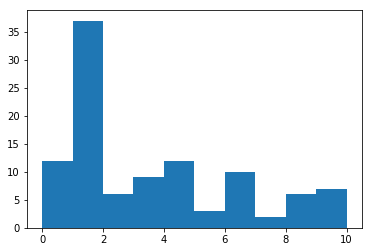

In [22]:
plt.hist(t['n3'],range=(0,10))

In [24]:
nr_qso = 10000
isub = np.hstack([i_lqso,np.random.choice(i_qso,size=nr_qso)])
Xp = X[isub,:]
yp = y[isub]
#clf = sktree.DecisionTreeClassifier()
clf = RandomForestClassifier()
clf.fit(Xp, yp)
#
ipred = np.where(clf.predict(X[i_qso,:]) == 1)[0]
tpred = t[i_qso[ipred]]
print ("potential LQSO: {} ({:.1f} %)".format(len(ipred),100*len(ipred)/n_qso))

potential LQSO: 42 (0.0 %)


(array([ 6., 18.,  6.,  1.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

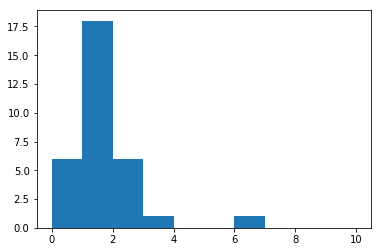

In [25]:
plt.hist(tpred['n3'],range=(0,10))

In [99]:
#
# now, keep only those with n3max less than xx arcsec
# 
rlimit = 5.0
ilimit = np.where(tpred['n3'].data <= 5.0)[0]
tout = tpred[ilimit]
print ("Total of {} candidates with max distance to 3rd neighbour less than {} arcsec".format(len(ilimit),rlimit))

Total of 50 candidates with max distance to 3rd neighbour less than 5.0 arcsec


In [100]:
tout

qso_name,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,type,mu,mu_error,n1,n2,n3,n3max
,,,,,yr,deg,mas,deg,mas,mas,mas,,mas.yr**-1,mas.yr**-1,mas.yr**-1,mas.yr**-1,,,,,,,,,,,,,,,,,mas,,,,mas**-2,um**-1,um**-1,,,,mas,,,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,mag,mag,mag,km.s**-1,km.s**-1,,K,log(cm.s**-2),'dex',,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,,,mas.yr**-1,mas.yr**-1,arcsec,arcsec,arcsec,arcsec
bytes18,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object,str4,float64,float64,float64,float64,float64,float64
286815888806335744,1635721458409799680,Gaia DR2 286815888806335744,286815888806335744,1197308913,2015.5,89.57098284698911,0.3446795900000857,63.9347519761824,0.3823068664739584,0.6232313183054641,0.6980225752696313,0.89285266,-0.07613269658288235,0.6459767300972241,-0.3557873387958923,0.6311996154491173,-0.21445452,0.41797638,0.41768962,-0.19029109,-0.37670553,-0.44527304,-0.06772786,0.5578354,0.17182718,0.10915433,235,0,235,0,1.9983356,274.8255,1.127105498276356,1.4398701845784672,31,True,0.088501945,1.5712567627747567,0.10467495911389185,0.007460747,28,12,0.7252258,3,35,False,262,242.05014141603436,1.9470597267129344,124.31573,19.728601,0,--,--,--,--,0,--,--,--,--,--,2,--,--,--,--,--,0,--,--,--,NOT_AVAILABLE,149.76024069848393,18.646097087118115,89.7521217355535,40.495840276832425,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,http://geadata.esac.esa.int/data-server/datalink/links?ID=286815888806335744,--,QSO,0.3638417484792589,0.6318538540102779,1.2683508067872706,2.733368623467581,3.2846791543599836,3.2846791543599836
286815888806335744,1635721458409799680,Gaia DR2 28